In [9]:
import geodatasets
import geopandas as gpd
import numpy as np
import rioxarray
import contextily as ctx
import matplotlib.pyplot as plt

import xarray as xr
import shapely

import xvec

In [67]:
ds = xr.tutorial.open_dataset("eraint_uvz")
world = gpd.read_file(geodatasets.get_path("geoda natregimes")).to_crs(4326)

/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'z' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'u' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'v' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)


In [79]:
aggregated = ds.xvec.zonal_stats(
    world.geometry,
    x_coords="longitude",
    y_coords="latitude",
    method="iterate",
    all_touched=True,
)

## Plotting DataArray using coordinate geometries

### 2D

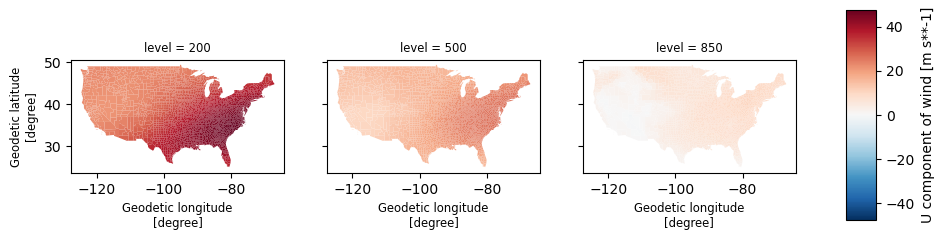

In [ ]:
f, ax = aggregated.u.sel(month=1).xvec.plot(col="level")


customisation

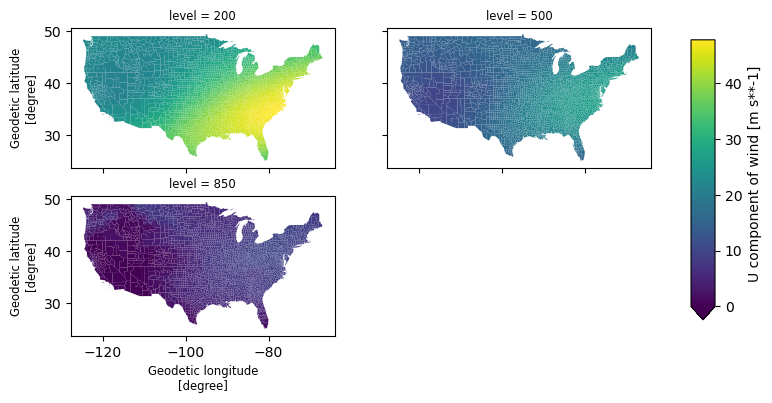

In [87]:
f, ax = aggregated.u.sel(month=1).xvec.plot(
    col="level", col_wrap=2, figsize=(8, 4), vmin=0
)

### 3D

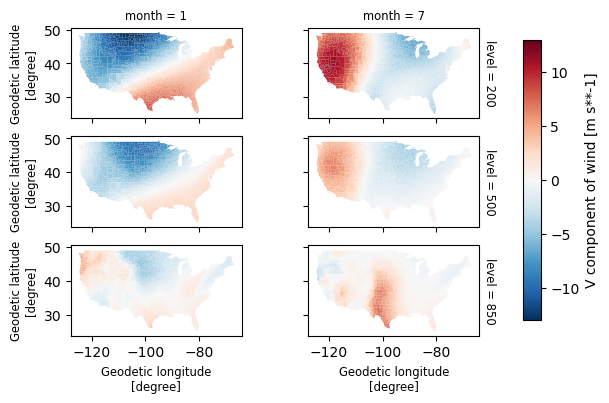

In [80]:
f, ax = aggregated.v.xvec.plot(col="month", row="level", figsize=(6, 4))

## Plotting on variable geometry

In [2]:
glaciers_df = gpd.read_file("_static/svalbard_glaciers_subset.gpkg")

In [ ]:
glaciers = (
    glaciers_df.set_index(["NAME", "YEAR_"])
    .to_xarray()
    .proj.assign_crs(spatial_ref=glaciers_df.crs)  # use xproj to store the CRS information
)
glaciers

<xarray.Dataset> Size: 244B
Dimensions:      (NAME: 4, YEAR_: 3)
Coordinates:
  * NAME         (NAME) object 32B 'Austre Brøggerbreen' ... 'Midtre Lovenbreen'
  * YEAR_        (YEAR_) int32 12B 1936 1990 2007
  * spatial_ref  int64 8B 0
Data variables:
    LENGTH       (NAME, YEAR_) float64 96B 5.808e+03 5.265e+03 ... 3.566e+03
    geometry     (NAME, YEAR_) object 96B MULTIPOLYGON (((432322.1074000001 8...
Indexes:
    spatial_ref  CRSIndex (crs=EPSG:32633)

In [4]:
glaciers = glaciers.xvec.summarize_geometry(
    dim="NAME", geom_array="geometry", aggfunc="concave_hull", ratio=0.2
)

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='Easting\n[metre]', ylabel='Northing\n[metre]'>)

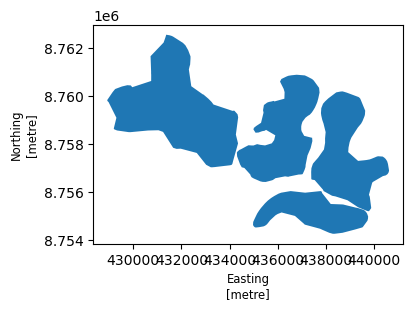

In [5]:
glaciers.xvec.plot(geometry="summary_geometry")

(<Figure size 1000x300 with 3 Axes>,
 array([[<Axes: title={'center': 'YEAR_ = 1936'}, xlabel='Easting\n[metre]', ylabel='Northing\n[metre]'>,
         <Axes: title={'center': 'YEAR_ = 1990'}, xlabel='Easting\n[metre]'>,
         <Axes: title={'center': 'YEAR_ = 2007'}, xlabel='Easting\n[metre]'>]],
       dtype=object))

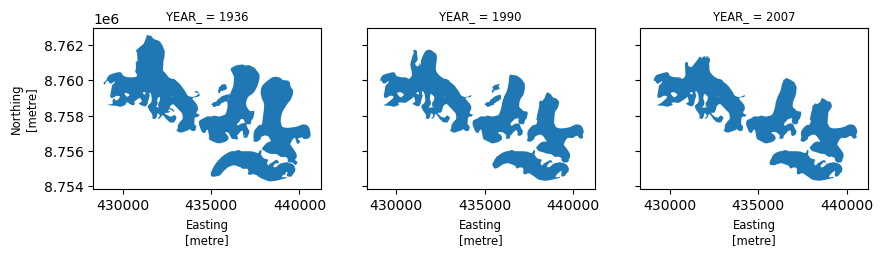

In [6]:
glaciers.geometry.xvec.plot(col="YEAR_")

(<Figure size 1000x300 with 3 Axes>,
 array([[<Axes: title={'center': 'YEAR_ = 1936'}, xlabel='Easting\n[metre]', ylabel='Northing\n[metre]'>,
         <Axes: title={'center': 'YEAR_ = 1990'}, xlabel='Easting\n[metre]'>,
         <Axes: title={'center': 'YEAR_ = 2007'}, xlabel='Easting\n[metre]'>]],
       dtype=object))

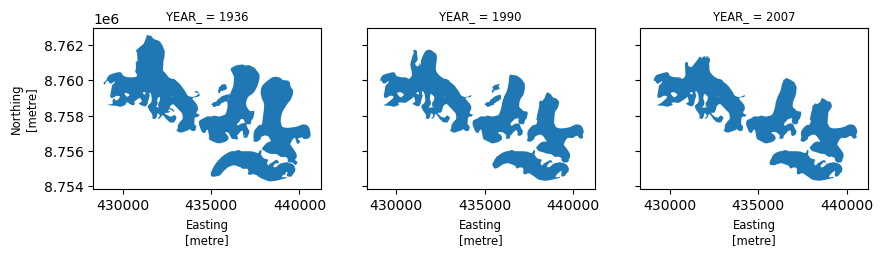

In [ ]:
glaciers.xvec.plot(col="YEAR_", geometry="geometry")

(<Figure size 1000x300 with 4 Axes>,
 array([[<Axes: title={'center': 'YEAR_ = 1936'}, xlabel='Easting\n[metre]', ylabel='Northing\n[metre]'>,
         <Axes: title={'center': 'YEAR_ = 1990'}, xlabel='Easting\n[metre]'>,
         <Axes: title={'center': 'YEAR_ = 2007'}, xlabel='Easting\n[metre]'>]],
       dtype=object))

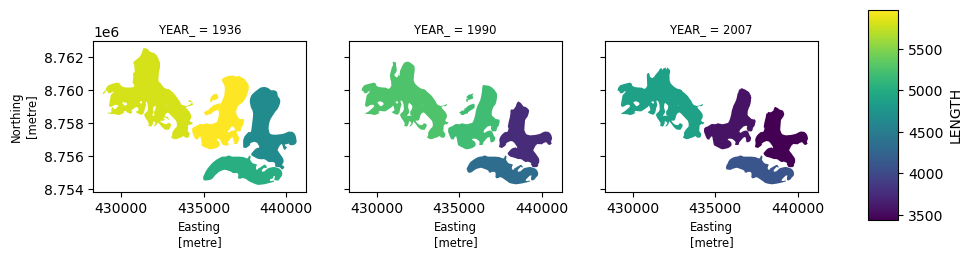

In [ ]:
glaciers.xvec.plot(col="YEAR_", geometry="geometry", hue="LENGTH")

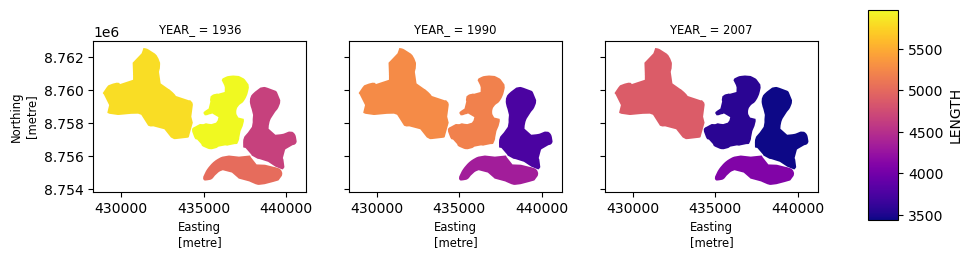

In [17]:
f, axs = glaciers.xvec.plot(
    col="YEAR_", geometry="summary_geometry", hue="LENGTH", cmap="plasma"
)